# Determining the Correct Orientation of the Post-Surgical T1 MRI To Feed Into Seg3D

Currently, Seg3D outputs segmentations as `.nrrd` files, which seem to also have a fixed RAS orientation. This is a problem if say we would like to overlay the T1 image of the Post-surgery onto the Pre-surgical T1 MRI.

For example, if there is a left/right flip, then the surgical segmentation is on the wrong hemisphere of the brain. 

What our current workflow does is:

0. robustfov: any "neck" is cropped out of the T1 MRI field of view
1. acpcdetect: T1 MRI is acpc aligned and RAS oriented 
2. coregistration: the Post-surgical T1 (acpc, RAS) is coregistered onto the Pre-surgical T1 MRI (acpc, RAS)
3. Seg3D: the coregistered Post-surgical T1 MRI (acpc, RAS) is annotated and outputs a `.nrrd` file with the image volume mask of the surgical segmentation
4. coregistration: The coregistered Post-surgical T1 (acpc, RAS) on the pre-surgical T1 MRI is then again coregistered to the FreeSurfer T1 MRI (256^3 LIA orientation, or we can apply whatever process FreeSurfer does. the coregistration here is a hack)
5. Apply transformation matrix to the seg3d mask to map it correctly to the FreeSurfer space.

Now, the coregistered Post-Surgical T1 from step 4 and the Freesurfer T1 MRI are in the same space and can be overlaid with anatomical masks, white matter masks, etc. 

## Validation
In order to confirm this flow, we currently have Post-Surgical T1 MRI annotated without acpc alignment. It auto orients to RAS. This poses some issues because then the coregistration transformation matrix we apply to get this image to FreeSurfer T1 image is incorrect.

We want to run all the above steps, and do a quick visualization of each: Let us use `la02` as an example.

In [1]:
### lOAD FUNCTIONS
import nibabel as nb
import numpy as np
import nrrd
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from mne_bids import make_bids_basename

In [2]:
### DEFINE FUNCTIONS
# visualize list of slices
def show_slices(slices):
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

def transform(coords, src_img, dest_img, transform_mat):
    import subprocess
    coords_str = " ".join([str(x) for x in coords])
    cp = subprocess.run(
        "echo %s | img2imgcoord -mm -src %s -dest %s -xfm %s"
        % (coords_str, src_img, dest_img, transform_mat),
        shell=True,
        stdout=subprocess.PIPE,
    )
    transformed_coords_str = cp.stdout.decode("ascii").strip().split("\n")[-1]
    return np.array([float(x) for x in transformed_coords_str.split(" ") if x])

# Load Data

Load the data from step 0-5.

In [72]:
# set subject and root path
subject = 'la02'
bids_root = Path("C:\\Users\\d0156\\Dropbox\\bids_layout_data")

### DEFINE FILE PATHS
# original T1 MRI nifti files
pret1_basename = make_bids_basename(subject=subject, session='presurgery', suffix='T1w.nii')
pret1_fpath = bids_root / f'sub-{subject}' / 'visualization' / pret1_basename

postt1_basename = make_bids_basename(subject=subject, session='postsurgery', suffix='T1w.nii')
postt1_fpath = bids_root / f'sub-{subject}' / 'visualization' / postt1_basename

# after running robust fov on both of them
robustfov_pret1_basename = make_bids_basename(subject=subject, session='presurgery', processing='robustfov', suffix='T1w.nii')
robustfov_pret1_fpath = bids_root / f'sub-{subject}' / 'visualization' / robustfov_pret1_basename

robustfov_postt1_basename = make_bids_basename(subject=subject, session='postsurgery', processing='robustfov', suffix='T1w.nii')
robustfov_postt1_fpath = bids_root / f'sub-{subject}' / 'visualization' / robustfov_postt1_basename

# after running acpcdetect on both of them
acpc_pret1_basename = make_bids_basename(subject=subject, session='presurgery', processing='newrobustfov', space='ACPC', suffix='T1w.nii')
acpc_pret1_fpath = bids_root / f'sub-{subject}' / 'visualization' / acpc_pret1_basename

acpc_postt1_basename = make_bids_basename(subject=subject, session='postsurgery', processing='newrobustfov', space='ACPC', suffix='T1w.nii')
acpc_postt1_fpath = bids_root / f'sub-{subject}' / 'visualization' / acpc_postt1_basename

# after first coregistration post on pre
postonpre_t1_basename = make_bids_basename(subject=subject, session='postsurgery', processing='postonpre', suffix='T1w.nii')
postonpre_t1_fpath = bids_root / f'sub-{subject}' / 'visualization' / postonpre_t1_basename

# after second coregistration using applyxfm
#app_postonpre_t1_basename = make_bids_basename(subject=subject, session='postonpre', processing='applyxfm', suffix='T1w.nii.gz')
#app_postonpre_t1_fpath = bids_root / f'sub-{subject}' / 'ses-postonpre' / app_postonpre_t1_basename

# after second conregistration using talairach.xfm
tal_postonpre_t1_basename = make_bids_basename(subject=subject, session='postsurgery', processing='secpostonpre', suffix='T1w.nii.gz')
tal_postonpre_t1_fpath = bids_root / f'sub-{subject}' / 'visualization' / tal_postonpre_t1_basename

In [73]:
# use nibabel and load
postt1 = nb.load(postt1_fpath)
pret1 = nb.load(pret1_fpath)

robustfov_pret1 = nb.load(robustfov_pret1_fpath)
robustfov_postt1 = nb.load(robustfov_postt1_fpath)

acpc_pret1 = nb.load(acpc_pret1_fpath)
acpc_postt1 = nb.load(acpc_postt1_fpath)

postonpre_t1 = nb.load(postonpre_t1_fpath)

app_postonpre_t1 = nb.load(app_postonpre_t1_fpath)
tal_postonpre_t1 = nb.load(tal_postonpre_t1_fpath)

In [44]:
# change data type 
print(robustfov_pret1.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 189 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.898     0.898     1.5000045 0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.3:b862cdd5'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.6146821
quatern_d       : -0.78877497
qoffset_x       : 113.762
qoffset_y  

In [45]:
# change data type from float32 to int16
robustfov_pret1_ndata = np.copy(robustfov_pret1.get_fdata())
robustfov_pret1_ndata = np.nan_to_num(robustfov_pret1_ndata)
hd = robustfov_pret1.header

new_dtype = np.int16  
robustfov_pret1_ndata = robustfov_pret1_ndata.astype(new_dtype)
robustfov_pret1.set_data_dtype(new_dtype)
new_robustfov_pret1 = nb.Nifti1Image(robustfov_pret1_ndata, robustfov_pret1.affine, header=hd)

nb.save(new_robustfov_pret1, "C:\\Users\\d0156\\Dropbox\\bids_layout_data\\sub-la02\\visualization\\sub-la02_ses-presurgery_proc-newrobustfov_T1w.nii")

In [46]:
print(robustfov_postt1.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 189 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.898    0.898    1.500003 0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.3:b862cdd5'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.6146821
quatern_d       : -0.78877497
qoffset_x       : 113.762
qoffset_y    

In [47]:
robustfov_postt1_ndata = np.copy(robustfov_postt1.get_fdata())
robustfov_post1_ndata = np.nan_to_num(robustfov_postt1_ndata)
hd = robustfov_postt1.header

new_dtype = np.int16  
robustfov_postt1_ndata = robustfov_postt1_ndata.astype(new_dtype)
robustfov_postt1.set_data_dtype(new_dtype)
new_robustfov_postt1 = nb.Nifti1Image(robustfov_postt1_ndata, robustfov_postt1.affine, header=hd)

nb.save(new_robustfov_postt1, "C:\\Users\\d0156\\Dropbox\\bids_layout_data\\sub-la02\\visualization\\sub-la02_ses-postsurgery_proc-newrobustfov_T1w.nii")

# Visualization and Basic Analysis


## RobustFOV - PreT1

In [9]:
# re-orient to RAS coordinates
ras_robustfov_pret1 = nb.as_closest_canonical(robustfov_pret1)

# load and check dimensions
ras_robustfov_pret1_data = ras_robustfov_pret1.get_fdata()
ras_robustfov_pret1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-presurgery_proc-robustfov_T1w.nii')

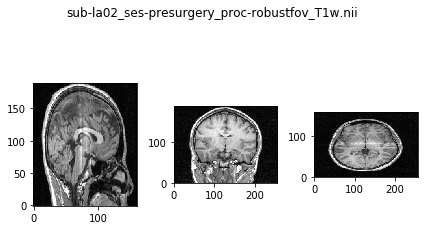

In [10]:
# visualize center slices (sagittal, coronal, axial)
slice_0 = ras_robustfov_pret1_data[128, :, :]
slice_1 = ras_robustfov_pret1_data[:, 80, :]
slice_2 = ras_robustfov_pret1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(robustfov_pret1_basename)

## RobustFOV - PostT1

In [11]:
# re-orient to RAS coordinates
ras_robustfov_postt1 = nb.as_closest_canonical(robustfov_postt1)
ras_robustfov_postt1_data = ras_robustfov_postt1.get_fdata()
ras_robustfov_postt1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-robustfov_T1w.nii')

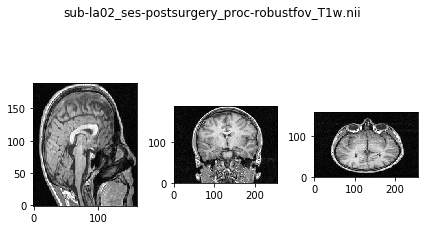

In [12]:
# visualize center slices (sagittal, coronal, axial)
slice_0 = ras_robustfov_postt1_data[128, :, :]
slice_1 = ras_robustfov_postt1_data[:, 80, :]
slice_2 = ras_robustfov_postt1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(robustfov_postt1_basename)

## ACPC Detect - PreT1

In [48]:
# re-orient to RAS coordinates
ras_acpc_pret1 = nb.as_closest_canonical(acpc_pret1)

# load and check dimensions 
ras_acpc_pret1_data = ras_acpc_pret1.get_fdata()
ras_acpc_pret1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-presurgery_proc-newrobustfov_space-ACPC_T1w.nii')

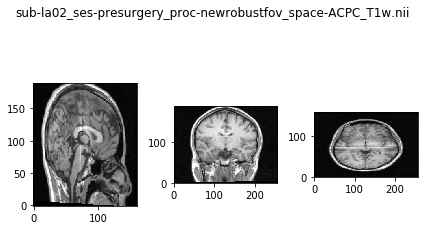

In [49]:
# visualize center slices (sagittal, coronal, axial)
slice_0 = ras_acpc_pret1_data[128, :, :]
slice_1 = ras_acpc_pret1_data[:, 80, :]
slice_2 = ras_acpc_pret1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(acpc_pret1_basename)

## ACPC Detect - PostT1

In [57]:
# re-orient to RAS coordinates
ras_acpc_postt1 = nb.as_closest_canonical(acpc_postt1)

# load and check dimensions
ras_acpc_postt1_data = ras_acpc_postt1.get_fdata()
ras_acpc_postt1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-newrobustfov_space-ACPC_T1w.nii')

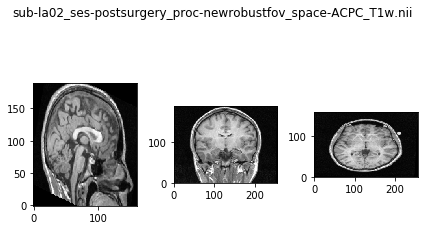

In [58]:
# visualize center slices (sagittal, coronal, axial)
slice_0 = ras_acpc_postt1_data[128, :, :]
slice_1 = ras_acpc_postt1_data[:, 80, :]
slice_2 = ras_acpc_postt1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(acpc_postt1_basename)

## First Coregistration PostT1 -> PreT1

In [59]:
# re-orient to RAS coordinates
ras_postonpre_t1 = nb.as_closest_canonical(postonpre_t1)

# load and check dimensions
ras_postonpre_t1_data = ras_acpc_postt1.get_fdata()
ras_postonpre_t1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-postonpre_T1w.nii')

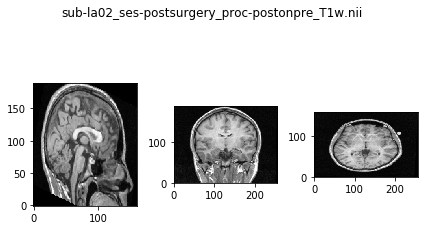

In [60]:
# visualize center slices (sagittal, coronal, axial)
slice_0 = ras_postonpre_t1_data[128, :, :]
slice_1 = ras_postonpre_t1_data[:, 80, :]
slice_2 = ras_postonpre_t1_data[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(postonpre_t1_basename)

## Seg3D Mask of PostT1 Segmentation

In [61]:
# load postmri mask
mask_post_basename = make_bids_basename(subject=subject, session='postsurgery', processing='seg', suffix='T1w.nrrd')
mask_post_fpath = bids_root / f'sub-{subject}' / 'visualization' / mask_post_basename
mask_post = open(mask_post_fpath, "rb")

# load nrrd file of postmri mask as array, check dimension
mask_post_data, header = nrrd.read(mask_post_fpath, index_order='F')
print(mask_post_data.shape)

(256, 160, 189)


Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-seg_T1w.nrrd')

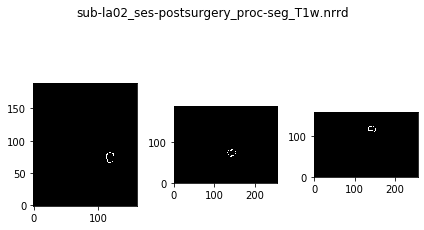

In [66]:
# visualize slices with ablation (sagittal, coronal, axial)
slice_0 = mask_post_data[145, :, :]
slice_1 = mask_post_data[:, 117, :]
slice_2 = mask_post_data[:, :, 75]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(mask_post_basename)

## Seg3D Mask on Post T1

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-seg_T1w.nrrd on sub-la02_ses-postsurgery_proc-robustfov_T1w.nii')

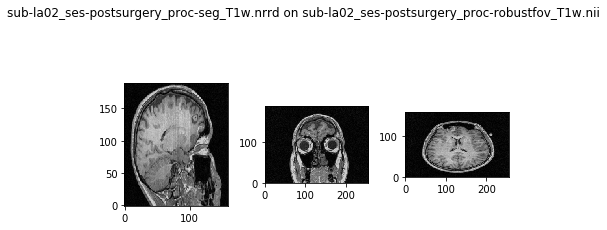

In [30]:
# postt1
slice_0 = ras_robustfov_postt1_data[111, :, :]
slice_1 = ras_robustfov_postt1_data[:, 119, :]
slice_2 = ras_robustfov_postt1_data[:, :, 114]

# seg3D mask of postt1
slice_01 = mask_post_data[145, :, :]
slice_11 = mask_post_data[:, 119, :]
slice_21 = mask_post_data[:, :, 75]

# overlay of postmri with its mask
# sagittal, coronal, axial from left to right
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(slice_0.T, cmap="gray", origin="lower", interpolation="none")
ax1.imshow(np.flipud(slice_01.T), cmap="gray", origin="lower", interpolation="none", alpha=0.2)

ax2.imshow(slice_1.T, cmap="gray", origin="lower", interpolation="none")
ax2.imshow(np.fliplr(np.flipud(slice_11.T)), cmap="gray", origin="lower", interpolation="none", alpha=0.2)

ax3.imshow(slice_2.T, cmap="gray", origin="lower", interpolation="none")
ax3.imshow(np.fliplr(slice_21.T), cmap="gray", origin="lower", interpolation="none", alpha=0.2)

plt.tight_layout()
plt.suptitle(mask_post_basename + " on " + robustfov_postt1_basename)

In [26]:
# affine matrix of postt1
ras_robustfov_postt1.affine

array([[   0.898     ,    0.        ,    0.        , -115.22799945],
       [   0.        ,    1.45454049,    0.21941006, -126.48405766],
       [   0.        ,   -0.36649862,    0.87078309,  -13.1171681 ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

## Seg3D Mask on Coregistered Image (postonpre)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-seg_T1w.nrrd on sub-la02_ses-postsurgery_proc-robustfov_T1w.nii')

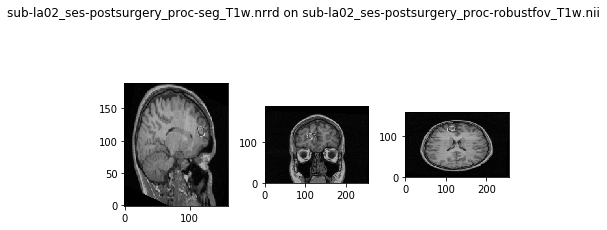

In [71]:
# postt1
slice_0 = ras_postonpre_t1_data[111, :, :]
slice_1 = ras_postonpre_t1_data[:, 117, :]
slice_2 = ras_postonpre_t1_data[:, :, 114]

# seg3D mask of postt1
slice_01 = mask_post_data[145, :, :]
slice_11 = mask_post_data[:, 117, :]
slice_21 = mask_post_data[:, :, 75]

# overlay of postmri with its mask
# sagittal, coronal, axial from left to right
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(slice_0.T, cmap="gray", origin="lower", interpolation="none")
ax1.imshow(np.flipud(slice_01.T), cmap="gray", origin="lower", interpolation="none", alpha=0.3)

ax2.imshow(slice_1.T, cmap="gray", origin="lower", interpolation="none")
ax2.imshow(np.fliplr(np.flipud(slice_11.T)), cmap="gray", origin="lower", interpolation="none", alpha=0.3)

ax3.imshow(slice_2.T, cmap="gray", origin="lower", interpolation="none")
ax3.imshow(np.fliplr(slice_21.T), cmap="gray", origin="lower", interpolation="none", alpha=0.3)

plt.tight_layout()
plt.suptitle(mask_post_basename + " on " + robustfov_postt1_basename)

## Second Coregistration Post -> Freesurfer Pre

### Using Applyxfm

In [25]:
# re-orient to RAS coordinates
ras_app_postonpre_t1 = nb.as_closest_canonical(app_postonpre_t1)

# load and check dimensions
ras_app_postonpre_t1_data = ras_app_postonpre_t1.get_fdata()
#ras_app_postonpre_t1_data_squeezed = np.squeeze(ras_app_postonpre_t1_data, axis = 3)
ras_app_postonpre_t1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postonpre_proc-applyxfm_T1w.nii.gz')

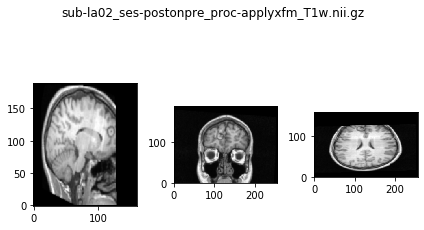

In [30]:
# visualize slices with ablation (sagittal, coronal, axial)
slice_0 = ras_app_postonpre_t1_data[112, :, :]
slice_1 = ras_app_postonpre_t1_data[:, 119, :]
slice_2 = ras_app_postonpre_t1_data[:, :, 116]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(app_postonpre_t1_basename)

### Using Talairach.xfm

In [74]:
# re-orient to RAS coordinates
ras_tal_postonpre_t1 = nb.as_closest_canonical(tal_postonpre_t1)

# load and check dimensions
ras_tal_postonpre_t1_data = ras_tal_postonpre_t1.get_fdata()
ras_tal_postonpre_t1_data.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la02_ses-postsurgery_proc-secpostonpre_T1w.nii.gz')

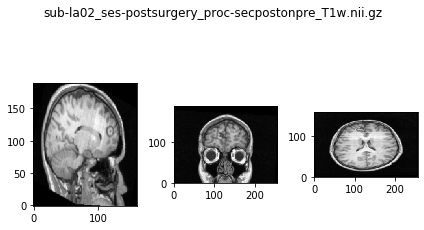

In [75]:
# visualize slices with ablation (sagittal, coronal, axial)
slice_0 = ras_tal_postonpre_t1_data[111, :, :]
slice_1 = ras_tal_postonpre_t1_data[:, 119, :]
slice_2 = ras_tal_postonpre_t1_data[:, :, 116]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(tal_postonpre_t1_basename)

### Using mri_vol2vol

In [77]:
# load second coregistered image
vol_postonpre_t1_basename = make_bids_basename(subject=subject, session='postsurgery', processing='postonpre', suffix='f-in-tal-1mm.nii')
vol_postonpre_t1_fpath = bids_root / f'sub-{subject}' / 'visualization' / vol_postonpre_t1_basename
vol_postonpre_t1 = nb.load(vol_postonpre_t1_fpath)

# re-orient to RAS coordinates
ras_vol_postonpre_t1 = nb.as_closest_canonical(vol_postonpre_t1)

# load and check dimensions 
ras_vol_postonpre_t1_data = ras_vol_postonpre_t1.get_fdata()
ras_vol_postonpre_t1_data.shape

(151, 186, 151)

## Seg3D mask mapped to Freesurfer Pre

In [19]:
# load xfm transformation file
postonpre_mat = bids_root / 'la02' / 'postsurgerymri' / 'sub-la02_from-presurgeryT1w_to-postsurgeryT1w_mode-image_xfm.mat'

In [20]:
# transform postmri mask to freesurfer space
posttopre_data = transform([256, 160, 189], mask_post_data, ras_acpc_pret1_data, postonpre_mat)
print(posttopre_data.shape)

(0,)


# Validation

To confirm, let us use 'la03' as a second example.

# Load Data

Load the data from step 0-5. 

In [21]:
# set subject and root path
subject = 'la03'
bids_root = Path("C:\\Users\\d0156\\Johns Hopkins\\Adam Li - epilepsy_bids")

### DEFINE FILE PATHS
# original T1 MRI nifti files
pret1_basename = make_bids_basename(subject=subject, session='presurgery', suffix='T1w.nii')
pret1_fpath = bids_root / f'sub-{subject}' / 'ses-presurgery' / 'anat' / pret1_basename

postt1_basename = make_bids_basename(subject=subject, session='postsurgery', suffix='T1w.nii')
postt1_fpath = bids_root / f'sub-{subject}' / 'ses-postsurgery' / 'anat' / postt1_basename

# after running robust fov on both of them
#robustfov_pret1_basename = make_bids_basename(subject=subject, session='presurgery', processing='robustfov', suffix='T1w.nii')
#robustfov_pret1_fpath = bids_root / f'sub-{subject}' / 'ses-presurgery' / 'anat' / robustfov_pret1_basename

#robustfov_postt1_basename = make_bids_basename(subject=subject, session='postsurgery', processing='inT1', space='RAS', suffix='T1w.nii.gz')
#robustfov_postt1_fpath = bids_root / f'sub-{subject}' / 'ses-postsurgery' / 'anat' / robustfov_postt1_basename

# after running acpcdetect on both of them
#acpc_pret1_basename = make_bids_basename(subject=subject, session='presurgery', space='RAS', suffix='T1w.nii')
#acpc_pret1_fpath = bids_root / f'sub-{subject}' / 'ses-presurgery' / 'anat' / acpc_pret1_basename

acpc_postt1_basename = make_bids_basename(subject=subject, session='postsurgery', space='RAS', suffix='T1w.nii.gz')
acpc_postt1_fpath = bids_root / f'sub-{subject}' / 'ses-postsurgery' / 'anat' / acpc_postt1_basename

# after coregistration post on pre
#postonpre_t1_basename = make_bids_basename(subject=subject, session='postonpre', suffix='T1w.nii.gz')
#postonpre_t1_fpath = bids_root / f'sub-{subject}' / 'coregistration' / postonpre_t1_basename


In [22]:
# use nibabel and load
postt1 = nb.load(postt1_fpath)
pret1 = nb.load(pret1_fpath)

#robustfov_pret1 = nb.load(robustfov_pret1_fpath)
#robustfov_postt1 = nb.load(robustfov_postt1_fpath)

#acpc_pret1 = nb.load(acpc_pret1_fpath)
acpc_postt1 = nb.load(acpc_postt1_fpath)

#postonpre_t1 = nb.load(postonpre_t1_fpath)

# Visualization and Basic Analysis

## RobustFOV - PreT1

## RobustFOV - PostT1

## ACPC Detect - PreT1

## ACPC Detect - PostT1

In [23]:
# re-orient to RAS coordinates
ras_acpc_postt1 = nb.as_closest_canonical(acpc_postt1)

# load and check dimensions
ras_acpc_postt1_data = ras_acpc_postt1.get_fdata()
ras_acpc_postt1_data_squeezed.shape

(256, 160, 189)

Text(0.5, 0.98, 'sub-la03_ses-postsurgery_space-RAS_T1w.nii.gz')

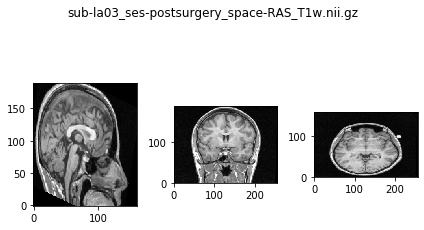

In [24]:
# visualize center slices (sagittal, coronal, axial)
slice_0 = ras_acpc_postt1_data_squeezed[128, :, :]
slice_1 = ras_acpc_postt1_data_squeezed[:, 80, :]
slice_2 = ras_acpc_postt1_data_squeezed[:, :, 94]
show_slices([slice_0, slice_1, slice_2])
plt.tight_layout()
plt.suptitle(acpc_postt1_basename)

## First Coregistration PostT1 -> PreT1

## Seg3D Mask of PostT1 Segmentation

## PostT1 and Seg3D Mask